In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from tensorflow import keras
import re
import nltk
import warnings
from wordcloud import WordCloud
%matplotlib inline

warnings.filterwarnings("ignore")

In [3]:
!unzip dataset.zip

unzip:  cannot find or open dataset.zip, dataset.zip.zip or dataset.zip.ZIP.


In [2]:
df = pd.read_csv('dataset/train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
df['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [4]:
df['text'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [6]:
df = df.drop(columns=['id', 'title', 'author'], axis=1)

In [7]:
#dropping the null values

df = df.dropna(axis=0)

In [8]:
#removing the special characters

df['clean_news'] = df['text'].str.lower()

df['clean_news'] = df['clean_news'].str.replace('[^A-Za-z0-9\s]', '', regex=True)
df['clean_news'] = df['clean_news'].str.replace('\n', '')
df['clean_news'] = df['clean_news'].str.replace('\s+', '')

df['clean_news']

0        house dem aide we didnt even see comeys letter...
1        ever get the feeling your life circles the rou...
2        why the truth might get you fired october 29 2...
3        videos 15 civilians killed in single us airstr...
4        print an iranian woman has been sentenced to s...
                               ...                        
20795    rapper t i unloaded on black celebrities who m...
20796    when the green bay packers lost to the washing...
20797    the macys of today grew from the union of seve...
20798    nato russia to hold parallel exercises in balk...
20799      david swanson is an author activist journali...
Name: clean_news, Length: 20761, dtype: object

In [9]:
#remove stopwords

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['clean_news'] = df['clean_news'].apply(lambda x: " ".join([word for word in x.split() if word not in stop]))
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label,clean_news
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide didnt even see comeys letter ja...
1,Ever get the feeling your life circles the rou...,0,ever get feeling life circles roundabout rathe...
2,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired october 29 2016 tension ...
3,Videos 15 Civilians Killed In Single US Airstr...,1,videos 15 civilians killed single us airstrike...
4,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six years prison...


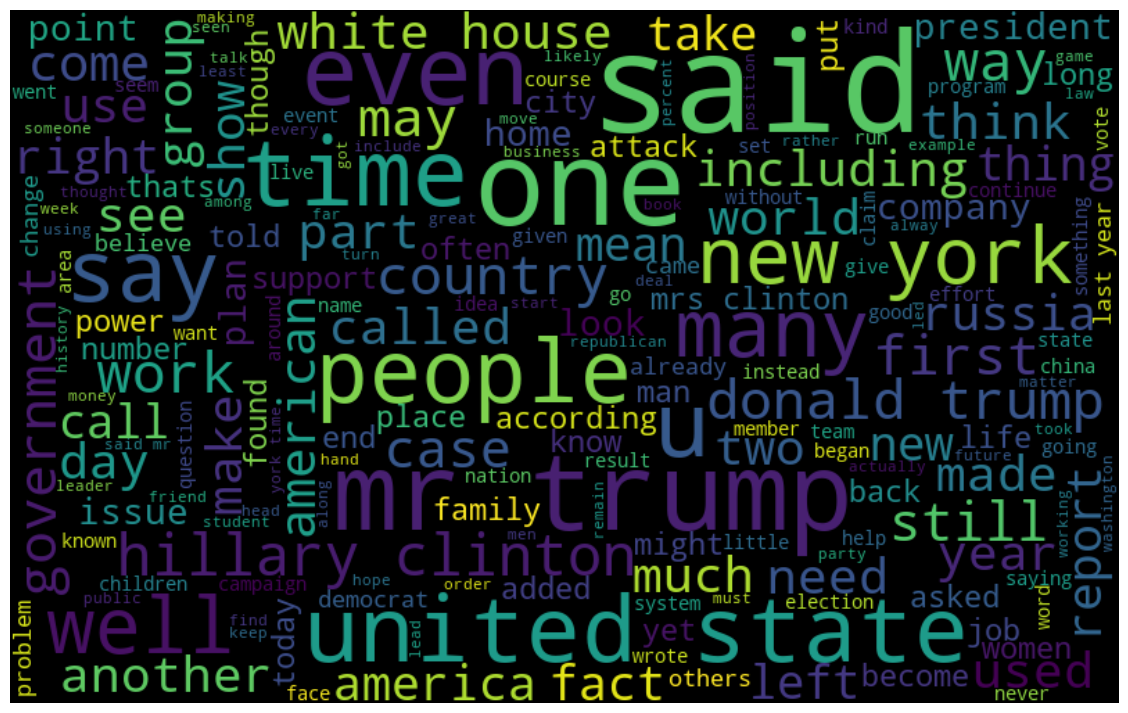

In [10]:
#visualize the frequent words

all_words = "".join([sentence for sentence in df['clean_news']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

#ploting the graph
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

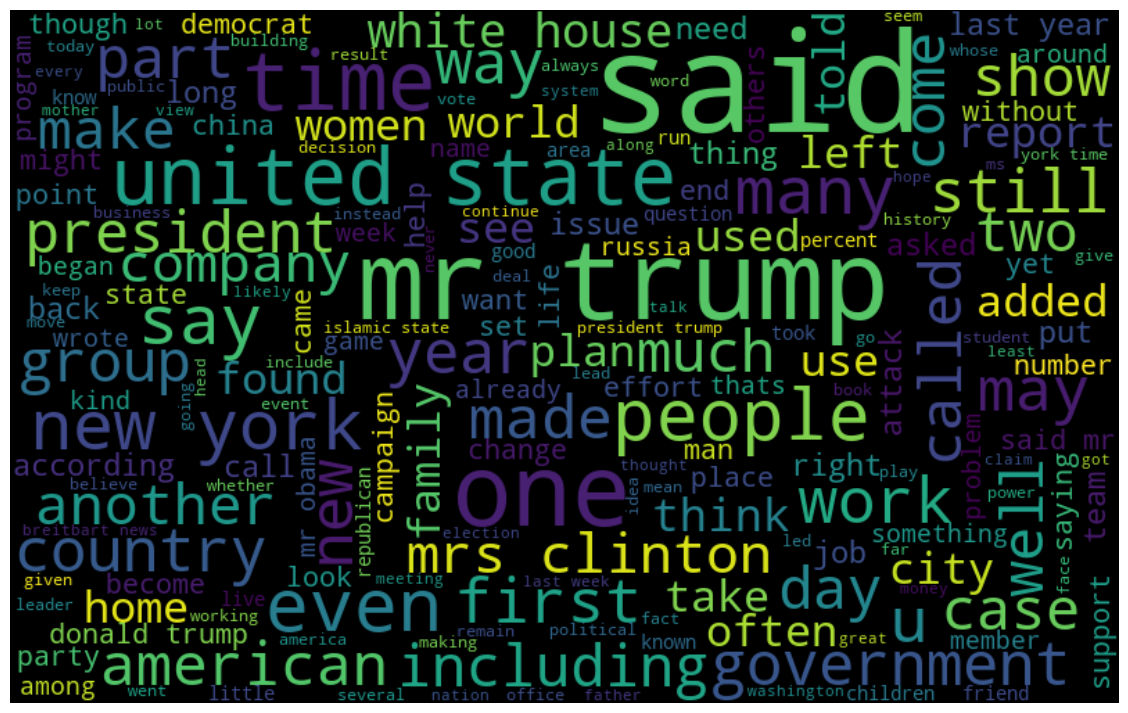

In [11]:
#visualize the frequent words for genuine news

all_words = "".join([sentence for sentence in df['clean_news'] [df['label']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

#ploting the graph
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
plt.show()

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_news'])
word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size

199536

In [18]:
# padding data
sequences = tokenizer.texts_to_sequences(df['clean_news'])
padded_seq = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

In [19]:
#creating embedded matrix

embedding_index = {}
with open('dataset/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [20]:
embedding_matrix = np.zeros((vocab_size + 1, 100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector



In [21]:
embedding_matrix[1]

array([-0.13128   , -0.45199999,  0.043399  , -0.99798   , -0.21053   ,
       -0.95867997, -0.24608999,  0.48413   ,  0.18178   ,  0.47499999,
       -0.22305   ,  0.30063999,  0.43496001, -0.36050001,  0.20245001,
       -0.52594   , -0.34707999,  0.0075873 , -1.04970002,  0.18673   ,
        0.57369   ,  0.43814   ,  0.098659  ,  0.38769999, -0.22579999,
        0.41911   ,  0.043602  , -0.73519999, -0.53583002,  0.19276001,
       -0.21961001,  0.42515001, -0.19081999,  0.47187001,  0.18826   ,
        0.13357   ,  0.41839001,  1.31379998,  0.35677999, -0.32172   ,
       -1.22570002, -0.26635   ,  0.36715999, -0.27586001, -0.53245997,
        0.16786   , -0.11253   , -0.99958998, -0.60706002, -0.89270997,
        0.65156001, -0.88783997,  0.049233  ,  0.67110997, -0.27553001,
       -2.40050006, -0.36989   ,  0.29135999,  1.34979999,  1.73529994,
        0.27000001,  0.021299  ,  0.14421999,  0.023784  ,  0.33643001,
       -0.35475999,  1.09210002,  1.48450005,  0.49430001,  0.15

In [23]:
#Input split

padded_seq[0]

array([    41,   5545,   2140,    216,     16,     54,   2349,    654,
         2892,   7162,   2772,  12400,  25043,    256,    533,     60,
         3036,   2892,   7162,  11700,     22,  14884,   4001,    978,
         4465,    618, 104289,    837,   2498, 104290,   2662,  11064,
         5704,  39129,   1319,   1392,    306,     27, 104291,    202,
          614,    477,     64,     41,    164,   2140,   1177,      8,
            9,     42, 104292,    306,     49,   1960,    477,    482,
        51962,    654,   3919,    188,    495,    254,     30,    922,
           29,    165,    144,   1271,   5651,    207,   3009,   3258,
          216,   1013,    477,    104,    984,   2111,      4,     95,
          374,  13105,     42,    477,   7044,     95,  13105,    164,
         5651,    163,     41,    331,   3897,   3980,   3258,    464,
         5380,    254,    388,   1322,    160,     54,   3112,   1445,
          151,     86,    654,    263,   3980,    374,    736,   2892,
      

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_seq, df['label'], test_size=0.2, random_state=42, stratify=df['label'])


In [25]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding
from tensorflow.keras import Sequential

model = Sequential([
    Embedding(vocab_size + 1, 100, weights=[embedding_matrix], trainable=True),
    Dropout(0.2),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [26]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    19,953,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,953,700 (76.12 MB)

 Trainable params: 19,953,700 (76.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 449s 3s/step - accuracy: 0.6209 - loss: 0.6460 - val_accuracy: 0.6730 - val_loss: 0.5862
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 527s 4s/step - accuracy: 0.6823 - loss: 0.5649 - val_accuracy: 0.6783 - val_loss: 0.5266
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 569s 4s/step - accuracy: 0.7460 - loss: 0.4862 - val_accuracy: 0.6858 - val_loss: 0.5413
Epoch 4/10
  3/130 ━━━━━━━━━━━━━━━━━━━━ 9:33 5s/step - accuracy: 0.7183 - loss: 0.5176 

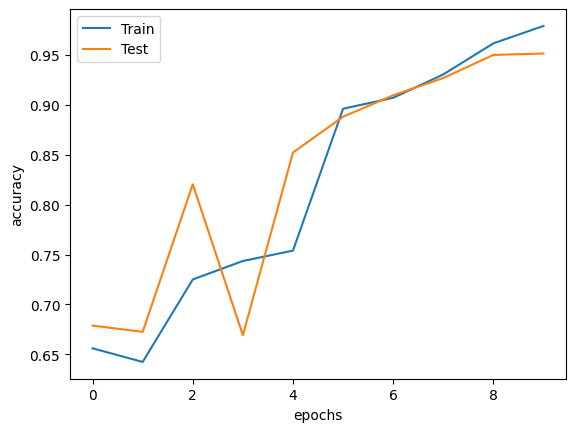

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.show()

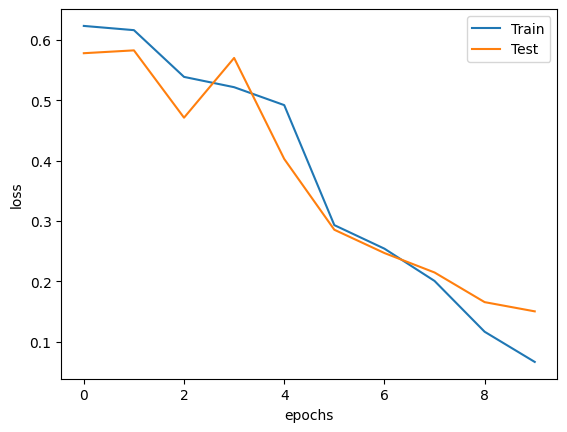

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Test'])
plt.show()

In [1]:
# Save the trained model to a file
model.save('fake_news_detection_model.h5')

NameError: name 'model' is not defined

In [33]:
def preprocess_input(text, tokenizer, maxlen=500):
    sequences = tokenizer.texts_to_sequences([text])
    padded_seq = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
    return padded_seq

def predict_news(text, model, tokenizer):
    preprocessed_text = preprocess_input(text, tokenizer)
    prediction = model.predict(preprocessed_text)
    return prediction[0][0]

user_input = input("Enter news text to check if it is fake or real: ")
prediction = predict_news(user_input, model, tokenizer)

if prediction >= 0.5:
    print(f"The news is likely fake with a probability of {prediction:.4f}.")
else:
    print(f"The news is likely real with a probability of {1 - prediction:.4f}.")

Enter news text to check if it is fake or real: Apple Introduces Revolutionary iPhone
1/1 [==============================] - 0s 30ms/step
The news is likely fake with a probability of 0.9964.
